In [73]:
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import gsw_xarray as gsw
from cmocean import cm as cmo  
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
file_path = '/Volumes/ctd_data$/OC4920/adcp_05_07_1356.txt'

# Read the data, skipping the header lines and using space as a delimiter
df = pd.read_csv(file_path, skiprows=12, sep='\t')
df.columns


Index(['Ens', 'YR', 'MO', 'DA', 'HH', 'MM', 'SS', 'HH.1', 'Unnamed: 8', 'Pit',
       'Rol', 'Hea', 'Eas', 'Eas.1', 'Eas.2', 'Eas.3', 'Eas.4', 'Eas.5',
       'Eas.6', 'Eas.7', 'Eas.8', 'Eas.9', 'Eas.10', 'Eas.11', 'Eas.12',
       'Eas.13', 'Eas.14', 'Eas.15', 'Eas.16', 'Eas.17', 'Eas.18', 'Eas.19',
       'Nor', 'Nor.1', 'Nor.2', 'Nor.3', 'Nor.4', 'Nor.5', 'Nor.6', 'Nor.7',
       'Nor.8', 'Nor.9', 'Nor.10', 'Nor.11', 'Nor.12', 'Nor.13', 'Nor.14',
       'Nor.15', 'Nor.16', 'Nor.17', 'Nor.18', 'Nor.19', 'Mag', 'Mag.1',
       'Mag.2', 'Mag.3', 'Mag.4', 'Mag.5', 'Mag.6', 'Mag.7', 'Mag.8', 'Mag.9',
       'Mag.10', 'Mag.11', 'Mag.12', 'Mag.13', 'Mag.14', 'Mag.15', 'Mag.16',
       'Mag.17', 'Mag.18', 'Mag.19', 'Dir', 'Dir.1', 'Dir.2', 'Dir.3', 'Dir.4',
       'Dir.5', 'Dir.6', 'Dir.7', 'Dir.8', 'Dir.9', 'Dir.10', 'Dir.11',
       'Dir.12', 'Dir.13', 'Dir.14', 'Dir.15', 'Dir.16', 'Dir.17', 'Dir.18',
       'Dir.19', 'BTE', 'NVD', '    "FLat"', '    "FLon"', '    "LLat"',
       '    "LL

In [100]:
east = (df[['Eas', 'Eas.1', 'Eas.2', 'Eas.3', 'Eas.4', 'Eas.5',
       'Eas.6', 'Eas.7', 'Eas.8', 'Eas.9','Eas.10','Eas.11',
       'Eas.12','Eas.13','Eas.14','Eas.15','Eas.16','Eas.17',
       'Eas.18','Eas.19']].iloc[2:].astype(float).to_numpy())

t = [datetime.datetime(2000+df["YR"][i+2].astype(int),
                    df["MO"][i+2].astype(int),
                    df["DA"][i+2].astype(int),
                    df["HH"][i+2].astype(int),
                    df["MM"][i+2].astype(int),
                    df["SS"][i+2].astype(int)) for i in range(len(df)-2)]

depth = np.array([8+i*4 for i in range(20)])

east_da = xr.DataArray(
    east,
    dims=["time", "depth"],
    coords={"time": t, "depth": depth},
    name="east_velocity"
)
north = (df[['Nor', 'Nor.1', 'Nor.2', 'Nor.3', 'Nor.4', 'Nor.5',
       'Nor.6', 'Nor.7', 'Nor.8', 'Nor.9','Nor.10','Nor.11',
       'Nor.12','Nor.13','Nor.14','Nor.15','Nor.16','Nor.17',
       'Nor.18','Nor.19']].iloc[2:].astype(float).to_numpy())

t = [datetime.datetime(2000+df["YR"][i+2].astype(int),
                    df["MO"][i+2].astype(int),
                    df["DA"][i+2].astype(int),
                    df["HH"][i+2].astype(int),
                    df["MM"][i+2].astype(int),
                    df["SS"][i+2].astype(int)) for i in range(len(df)-2)]

depth = np.array([8+i*4 for i in range(20)])

north_da = xr.DataArray(
    north,
    dims=["time", "depth"],
    coords={"time": t, "depth": depth},
    name="north_velocity"
)
df['lat'] = np.array([x.replace(',', '.') for x in df["    \"FLat\""].astype(str)])
df['lon'] = np.array([x.replace(',', '.') for x in df["    \"FLon\""].astype(str)])
ds = xr.merge([north_da,east_da,])
ds = ds.where(np.logical_and(np.abs(ds.north_velocity)<500,np.abs(ds.east_velocity)<500))
ds["lat"] = ("time"), df['lat'].values[2:].astype(float)
ds["lon"] = ("time"), df['lon'].values[2:].astype(float)
ds = ds.set_coords("lat")
ds = ds.set_coords("lon")
ds["north_velocity"] = ds["north_velocity"]/1000
ds["east_velocity"] = ds["east_velocity"]/1000

In [102]:
ds = ds.where(ds.time >= np.datetime64('2025-05-07T09:40:00'), drop=True)

In [107]:
v

'north_velocity'

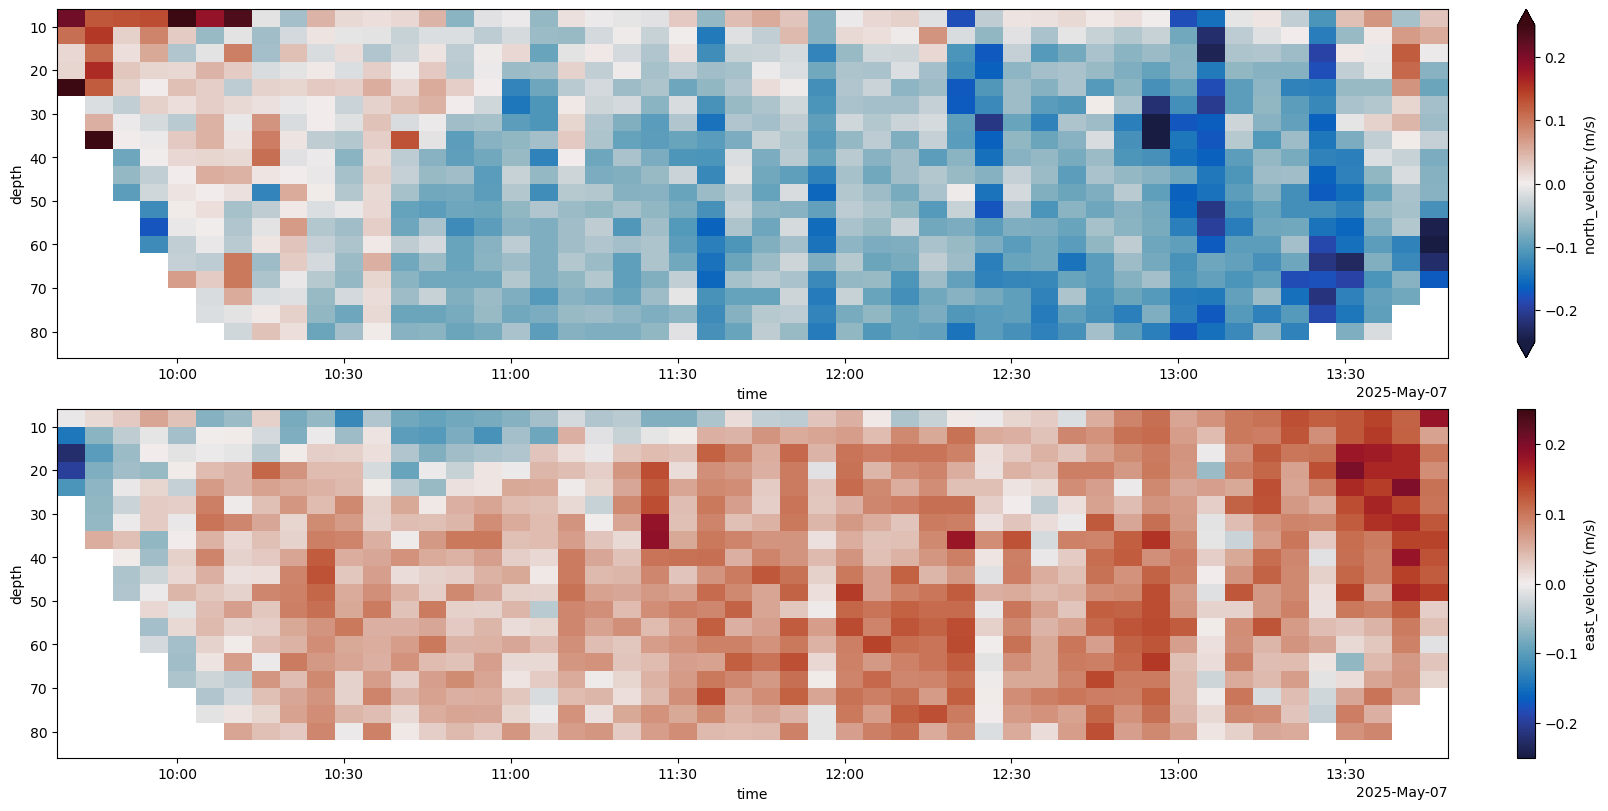

In [111]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds[v].T.plot(ax=ax,cmap=cmo.balance,yincrease=False,vmax=0.25,vmin=-0.25,cbar_kwargs={'label': '{} (m/s)'.format(v)})

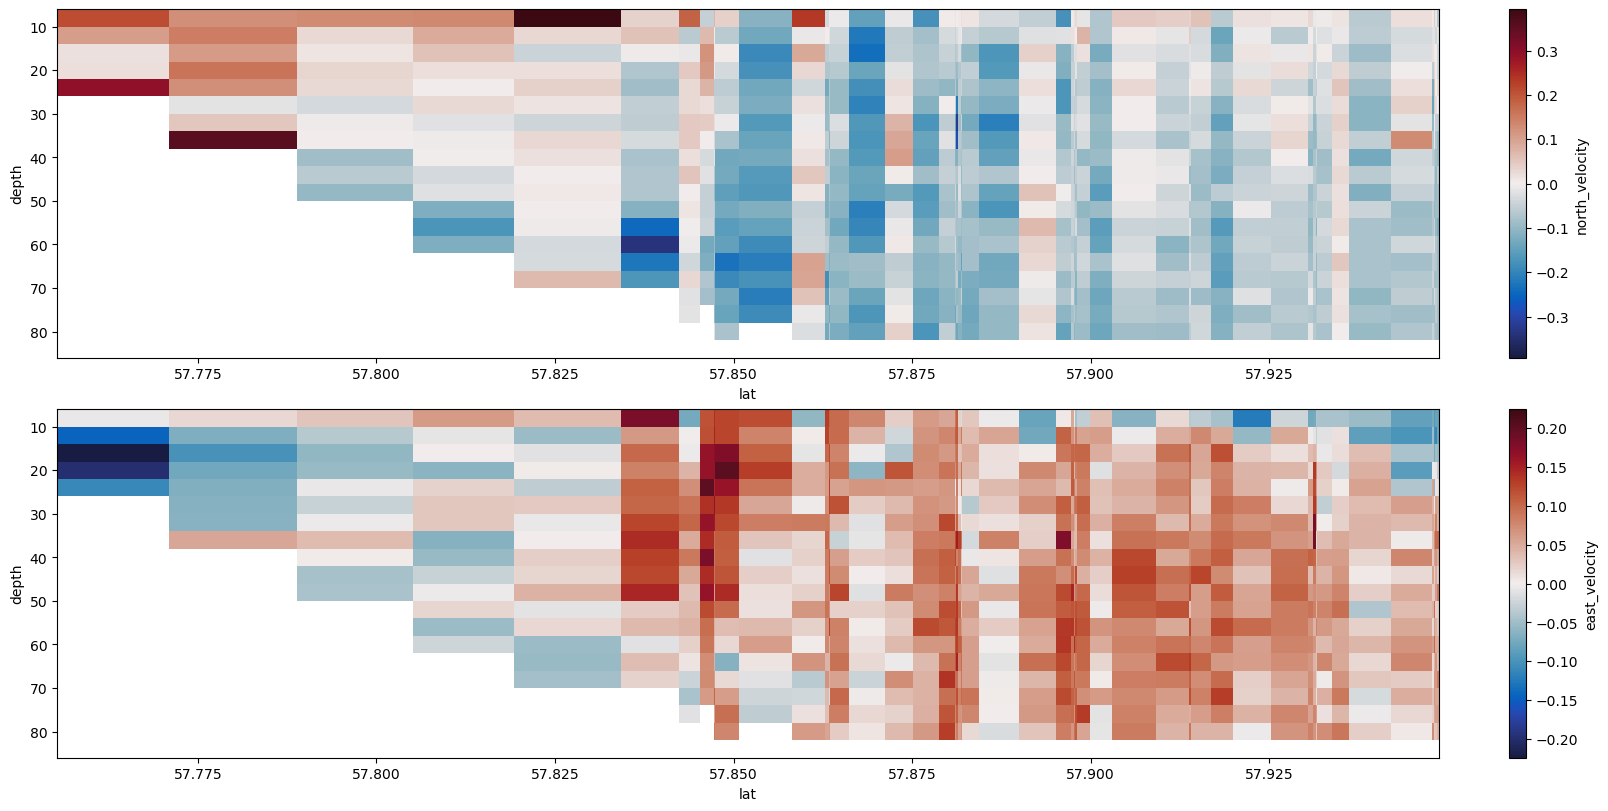

In [121]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds[v].sortby("lat").plot(x="lat",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)


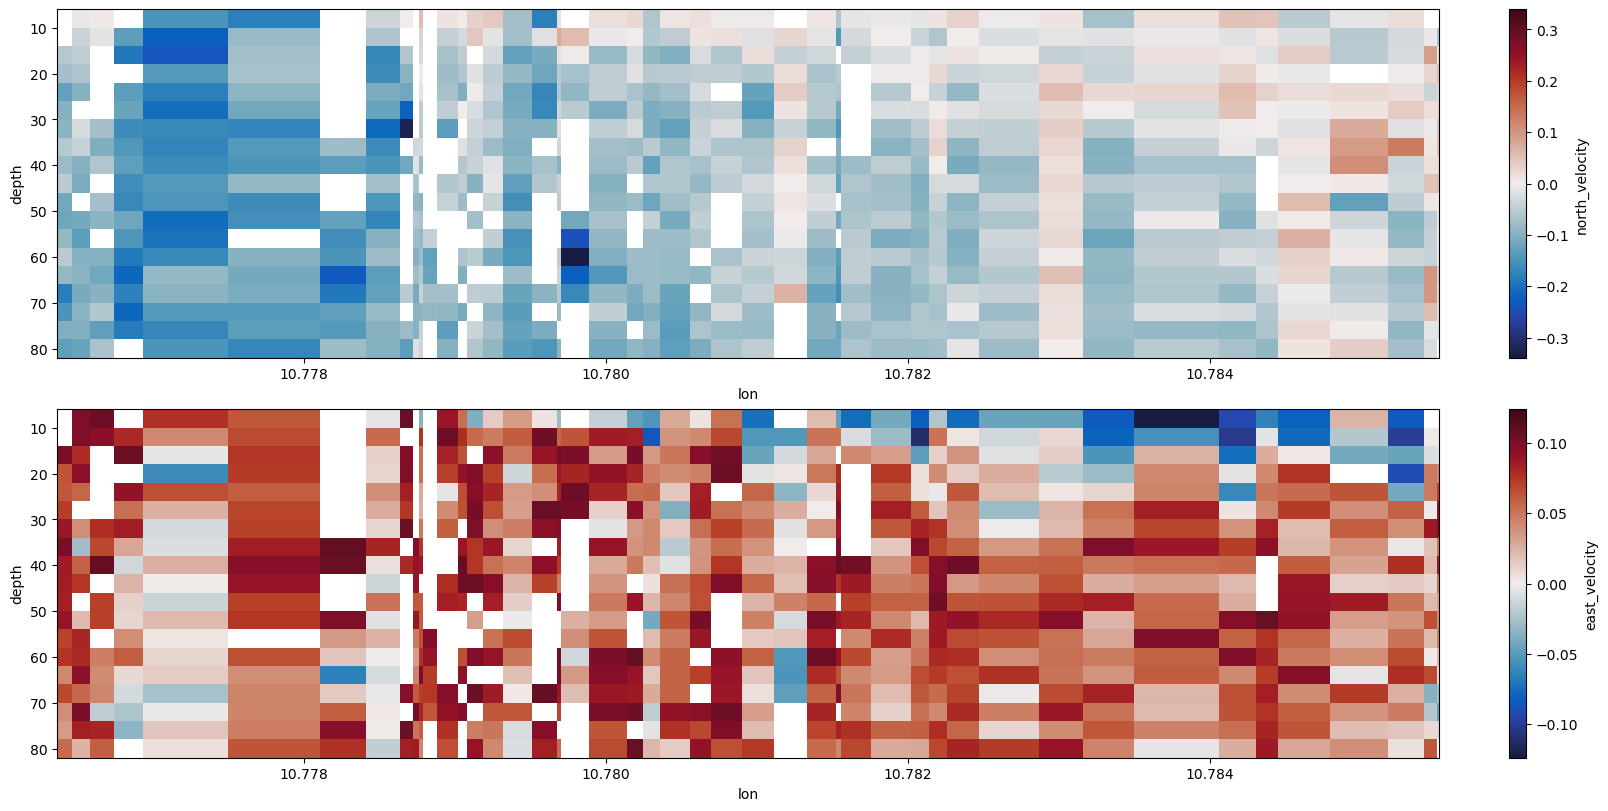

In [158]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds_test[v].where(ds.lon>10.775,drop=True).sortby("lon").plot(x="lon",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)
    # ax.set_ylim(45,0)

In [150]:
ds_test

<xarray.Dataset> Size: 17kB
Dimensions:         (time: 50, depth: 19)
Coordinates:
  * time            (time) datetime64[ns] 400B 2025-05-07T09:40:55 ... 2025-0...
  * depth           (depth) int64 152B 8 12 16 20 24 28 32 ... 60 64 68 72 76 80
    lat             (time) float64 400B 57.76 57.78 57.8 ... 57.85 57.85 57.84
    lon             (time) float64 400B 10.75 10.76 10.77 ... 10.78 10.78 10.78
Data variables:
    north_velocity  (time, depth) float64 8kB nan 0.106 0.018 ... nan nan nan
    east_velocity   (time, depth) float64 8kB nan -0.144 -0.224 ... nan nan nan

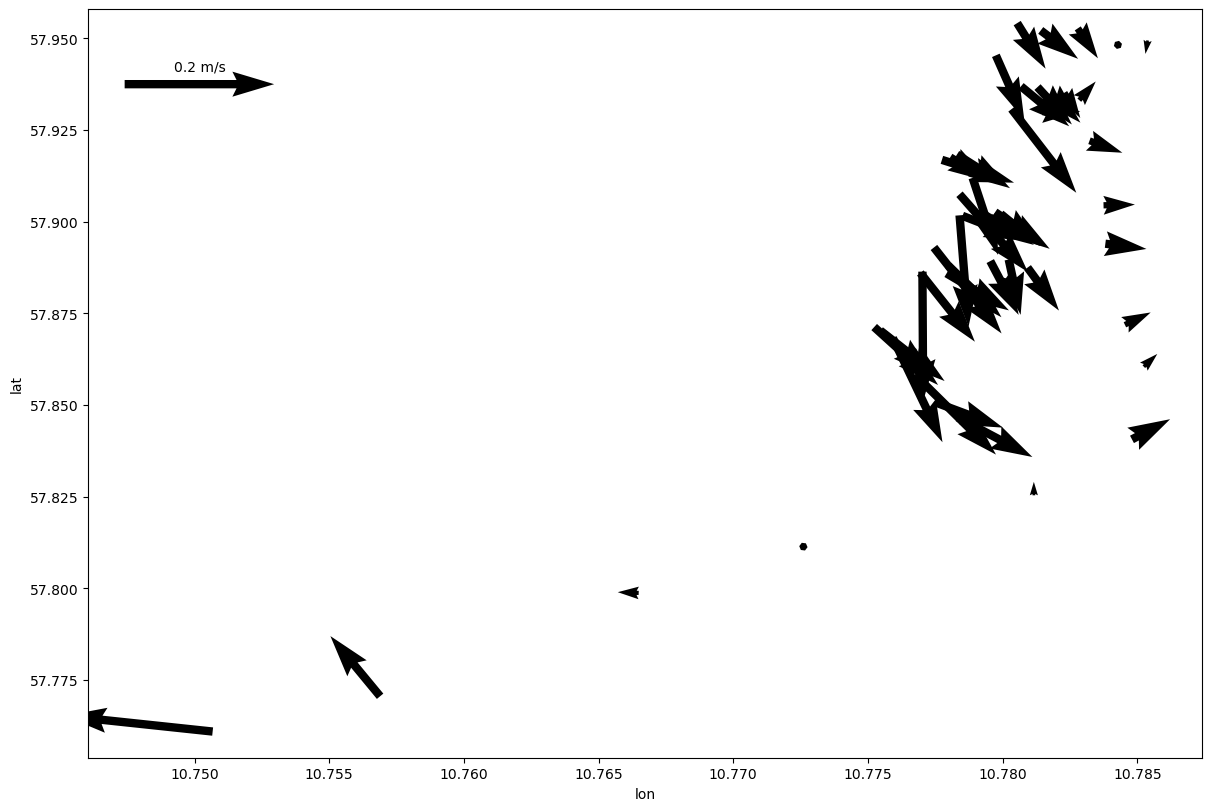

In [157]:
fig,ax = plt.subplots(1,1,figsize=(12,8),constrained_layout=True)

q = ds_test.isel(depth=slice(1,10)).median("depth").plot.quiver(x="lon",
                                                       y="lat",
                                                       u="east_velocity",
                                                       v="north_velocity",
                                                       ax=ax,
                                                       add_guide=False)

ax.quiverkey(q,0.1,0.9,0.2,"0.2 m/s",transform=ax.transAxes)

In [140]:
ds.north_velocity.std()*2

<xarray.DataArray 'north_velocity' ()> Size: 8B
array(0.13593714)

In [143]:
ds_test = ds.where((ds.north_velocity<ds.north_velocity.std()*2)&(ds.east_velocity<ds.east_velocity.std()*2),drop=True)

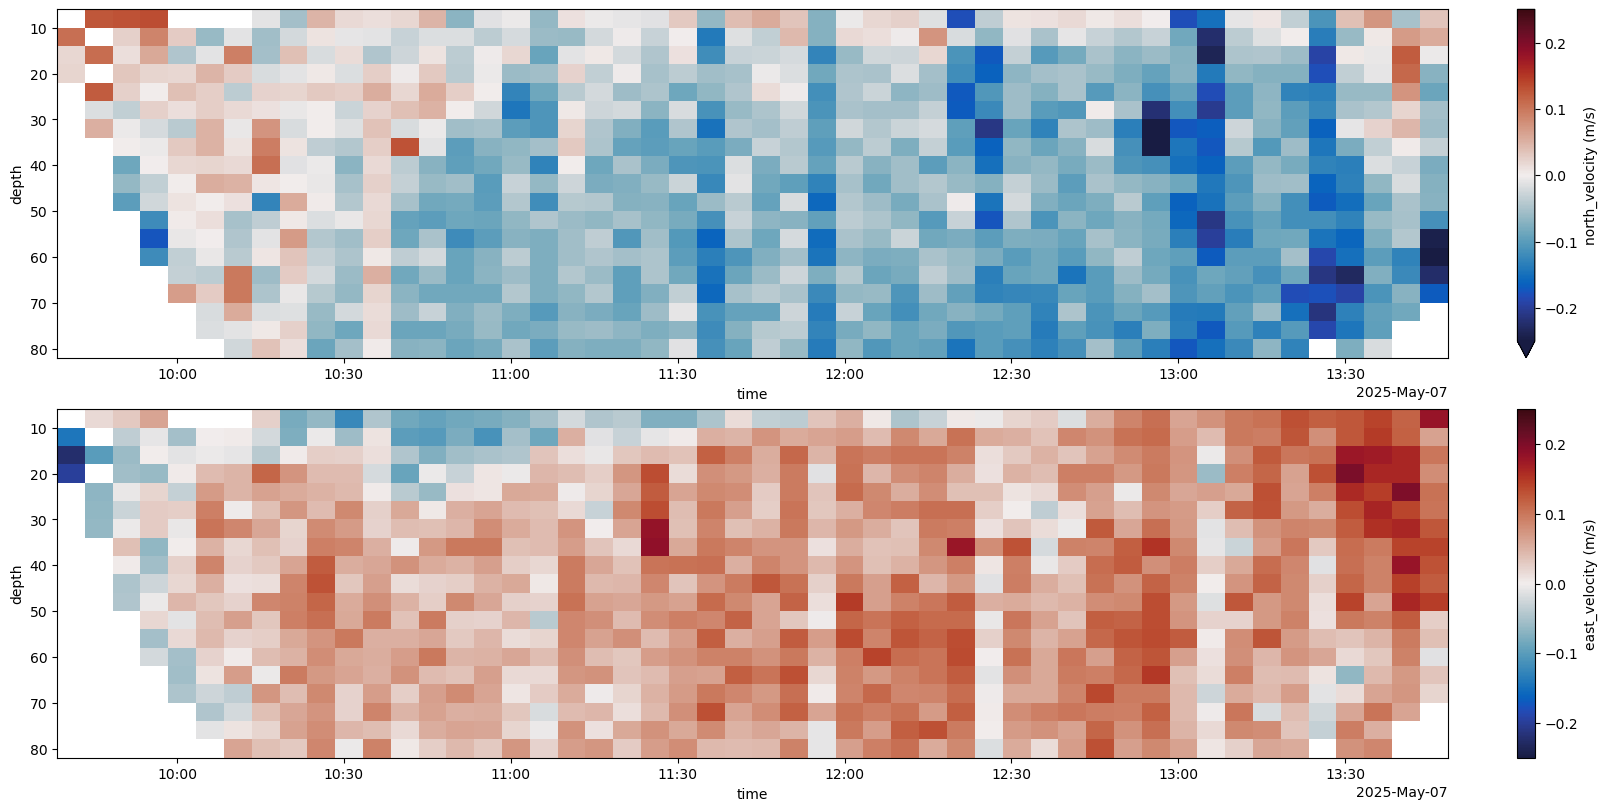

In [135]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds_test[v].T.plot(ax=ax,cmap=cmo.balance,yincrease=False,vmax=0.25,vmin=-0.25,cbar_kwargs={'label': '{} (m/s)'.format(v)})

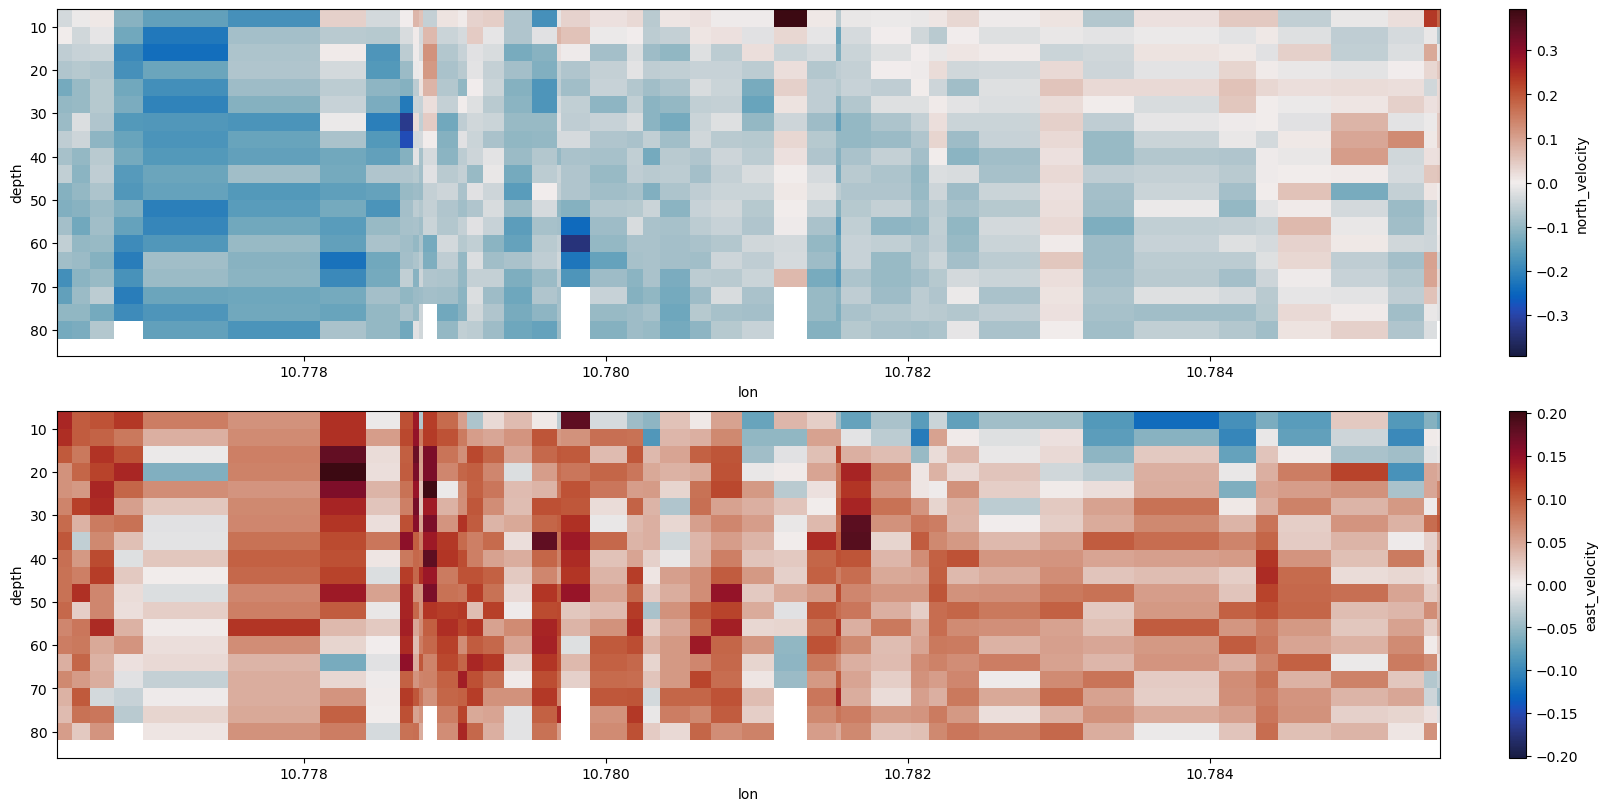

In [136]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds[v].where(ds.lon>10.775,drop=True).sortby("lon").plot(x="lon",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)
    # ax.set_ylim(45,0)

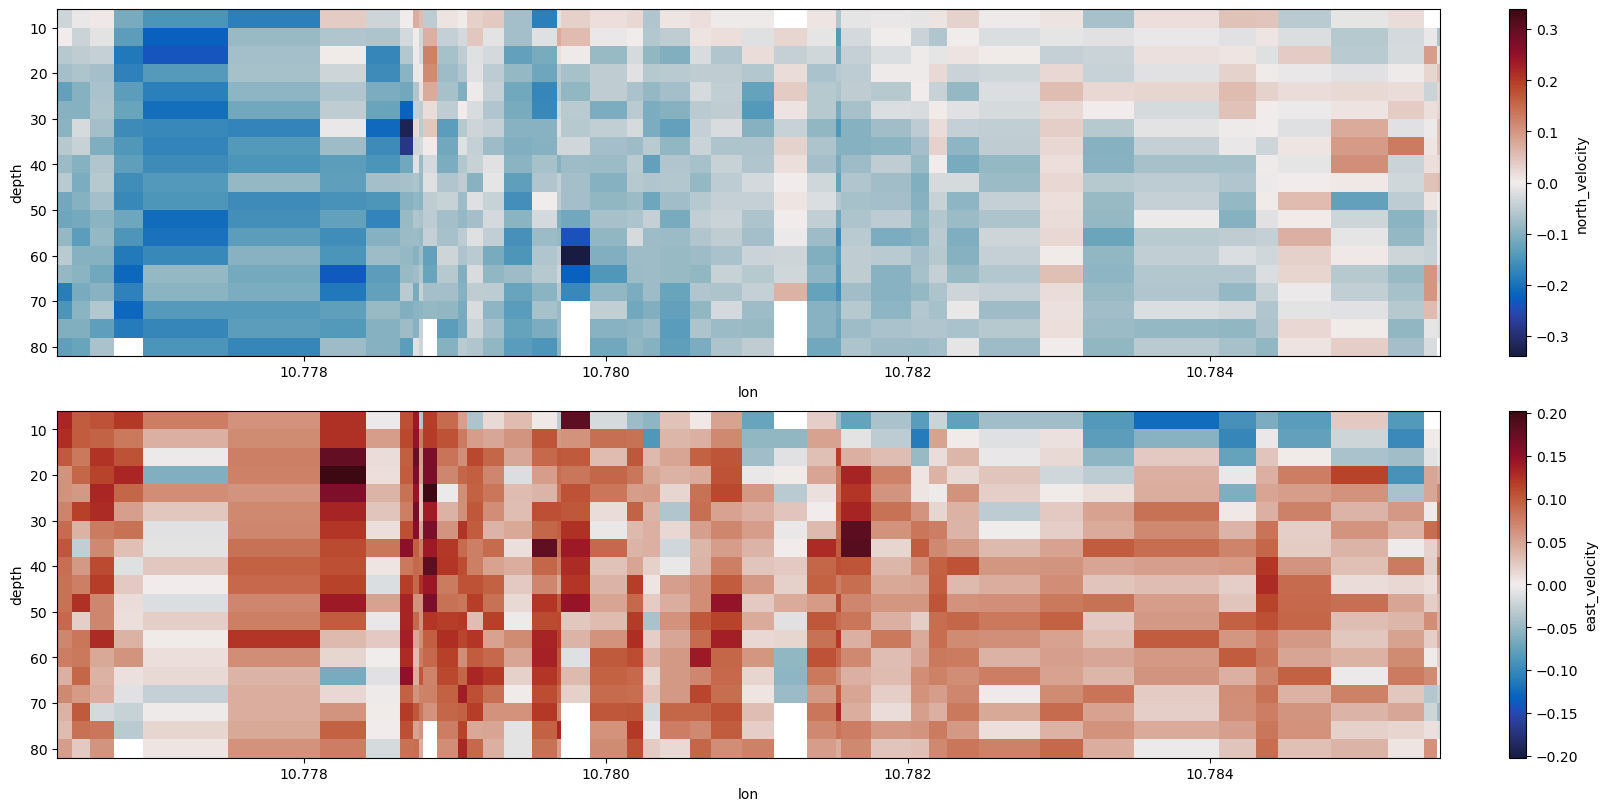

In [137]:
fig,axs = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)

variables = ["north_velocity","east_velocity"]

for ax,v in zip(axs,variables):
    ds_test[v].where(ds_test.lon>10.775,drop=True).sortby("lon").plot(x="lon",y="depth",yincrease=False,ax=ax,cmap=cmo.balance)
    # ax.set_ylim(45,0)